<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/neuro-morphology/Coding/LTP/correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Structural plasticity controlled by calcium based correlation detection**

## Top tips
- Hebbian rule shows the importance of correlation between pre- and post-synapse.
- The correlation is usually represented by spiking-time but structurally effected by three process: synapse formation, potential/depress, synapse pruning.
- the calcium concentration in spines was experimentally shown to be a correlation sensitive signal. NMDA receptors are a candidate mediator for the correlation dependent calcium signal
- Here they establish a quantitative model of correlation detection in synapses based on the calcium influx through NMDA receptors under realistic conditions of irregular pre- and postsynaptic spiking activity with pairwise correlation.
- find a simple threshold mechanism sensitive to correlation, whch mechanism controls synapse formation and elimination. They show that the connectivity structure is shaped by the correlations between neighboring inputs.
Structural plasticity controlled by calcium based correlation detection

## Basic biochemical process

- Newly formed synapses are created in an intermediate, silent state. These frequently encountered silent synapses lack AMPA receptors but have NMDA receptors. The most probable mechanism is the translocation of AMPA receptors into the postsynaptic density (PSD).
- LTP and LTD are in a bistate dependent on correlation made by spiking. The underlying mechanisms may be similar.
- presynapse Ca2+ release, NMDA activate mechanism, Calcium activate CaMKII, CaMKII phosphorylate AMPA receptor to increase AMPA conductivity and insertion.
- CaMKII forms holoenzymes with 6 subunits triggered by different calcium signal level. Short, weak level activate one subunit and deactivate after the level drops; higher level an active subunit can phosphorylate the neiboring subunit and remain active. At resting calcium level, PP1 can dephosphorylate an active subunit but a neighboring active site can immediately rephosphorylate it again. 
- Calcium also activate PP1 which dephosphorylate CaMKII-- long time scale, bistable of LTP and LTD

## Discussion
- some parameters are not based on experiments, but on analytic convenience
- current model can not reproduce the part of the rule expressing LTD

In [1]:
# if you want to use or haven't installed brainpy 
# pip install -U brain-py

In [1]:
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy import integrate

In [2]:
bp.__version__

'1.0.3'

In [3]:
dt = 0.5
bp.backend.set(dt=dt)

In [4]:
## Parameters setting
tau_m = 10  # [ms]
g_L = 1  # [mS/mm2]
E_L = -65  # [mV]
E_ampa = 60  # [mV]
E_nmda = 0  # [mV]
tau_V = 10/9  # classical [ms] 2, 4/3, 2/3, 100, 4/3, 20, 9/8, 2.5
tau_G = 20  # classical [ms] 2, 20, 20, 1, 2, 20, 2, 20

bar_g_nmda = 0.01  # [mS/mm2]
tau_p = 1.5  # [ms]
alpha_p = 0.5
tau_n = 152  # [ms]
alpha_n = 0.5
Mg2 = 1  # [mM]
alpha = 10
tau_Ca = 530  # [ms]

bar_g_ampa = 0.05  # [mS/mm2]
tau_ampa = 5.26  # tau_n fo P_n in AMPA [ms]

phi_f = 1e-5
phi_s = 0.1
alpha_s = 7.4e-6
tau_f = 3.5  # [ms]
tau_s = 8  # [ms]

alpha_Af = 0.1


In [10]:
# LIF model with delta-shaped postsynaptic currents
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, V_lp, t, Iext, tau_V, g_ampa, g_nmda):
    I_leak = g_L * (V - E_L)
    I_ampa = g_ampa * (V - E_ampa)
    I_nmda = g_nmda * (V - E_nmda)
    dV = (- I_ampa - I_nmda - I_leak + Iext) / tau_m
    dV_lp = (V - V_lp) / tau_V

    return dV, dV_lp

  def __init__(self, size, t_ref=1., g_ampa=0., g_nmda=0., tau_V=10/9,
               V_rest=-65., V_reset=-65., V_th=-50., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # parameters
    self.t_ref = t_ref
    self.g_ampa = g_ampa
    self.g_nmda = g_nmda
    self.tau_V = tau_V
    self.V_th = V_th
    self.V_reset = V_reset
    self.V_rest = V_rest

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * self.V_rest
    self.V_lp = bp.ops.ones(self.num) * self.V_rest
    self.input = bp.ops.zeros(self.num)
    self.g_ampa = bp.ops.zeros(self.num)
    self.g_nmda = bp.ops.zeros(self.num)

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V, V_lp = self.integral(self.V[i], self.V_lp[i], _t, self.input[i],
                    self.tau_V, self.g_ampa[i], self.g_nmda[i])
        spike = (V > self.V_th)
        spike_reset = (V > self.V_th + 2)
        if spike_reset:
          V = self.V_reset
          # V_lp = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
        self.V_lp[i] = V_lp
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.

max V: [-49.77398689]


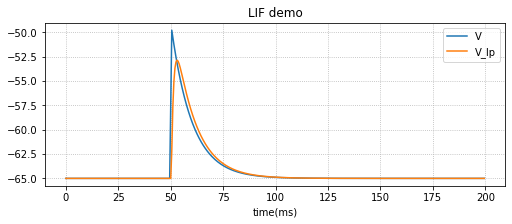

In [11]:
## LIF
tau_V = 0.5
t_duration = 200
idx_duration = int(t_duration/dt)
input_I = bp.ops.zeros(idx_duration)
idx_spike = int(50/dt)
idx_spike_duration = int(1/dt)
input_I[idx_spike: idx_spike+idx_spike_duration] = 160

lif = LIF(size=1, monitors=['V', 'V_lp'])  # size is the iteration rounds
# duration is the real time
lif.run(duration=t_duration, inputs=('input', input_I))

# plot
fig, gs = bp.visualize.get_figure(row_num=1, col_num=1, row_len=3, col_len=7)

fig.add_subplot(gs[0, 0])
plt.plot(lif.mon.ts, lif.mon.V[:, 0], label='V')
plt.plot(lif.mon.ts, lif.mon.V_lp[:, 0], label='V_lp')
plt.legend()
plt.title('LIF demo')
plt.xlabel('time(ms)')
plt.grid(linestyle='dotted')
print('max V:', max(lif.mon.V))


In [12]:
class Synapse(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint # (method='exponential_euler')
  def integral(P_p, P_n, P_n_ampa, sim_G, c_Ca, w, A_f, A_s, t, I_Ca_h, V_lp, tau_G):
    dP_p = (1 - P_p) / tau_p
    dP_n = (0 - P_n) / tau_n
    dP_n_ampa = (0 - P_n_ampa) / tau_ampa
    G = 1 / ( 1 + Mg2/3.56 * np.exp(-V_lp/16.12) )
    dsim_G = (-sim_G + G) / tau_G
    dc_Ca = ( ( - c_Ca) - alpha *I_Ca_h ) / tau_Ca # revised the formula in paper
    P_nmda = P_p * P_n
    g_nmda = bar_g_nmda * P_nmda * sim_G
    I_Ca = (1 - c_Ca) * g_nmda * (V_lp - E_nmda)

    H1 = np.heaviside(np.abs(A_f)-phi_f, 0)
    H2 = np.heaviside(A_s-phi_s, 0)

    delta_I_Ca = (I_Ca - I_Ca_h) / dt
    dw = A_f*H1 - alpha_s*A_s*H2
    dA_f = (-A_f + alpha_Af*(1-A_f)*delta_I_Ca) / tau_f
    dA_s = (-A_s - (1 - A_s)*I_Ca) / tau_s

    return dP_p, dP_n, dP_n_ampa, dsim_G, dc_Ca, dw, dA_f, dA_s

  def __init__(self, pre, post, conn, tau_G=20., **kwargs):
    super(Synapse, self).__init__(pre=pre, post=post, **kwargs)
    # parameters
    self.tau_G = tau_G

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.size = len(self.pre_ids)

    # variables
    self.P_p = bp.ops.ones(self.size)
    self.P_n = bp.ops.zeros(self.size)
    self.P_n_ampa = bp.ops.zeros(self.size)
    self.G = bp.ops.zeros(self.size)
    self.sim_G = bp.ops.ones(self.size) * 1 / ( 1 + Mg2/3.56 * np.exp(-E_L/16.12) )
    self.c_Ca = bp.ops.zeros(self.size)
    self.g_nmda = bp.ops.zeros(self.size)
    self.g_ampa = bp.ops.zeros(self.size)
    self.I_Ca = bp.ops.zeros(self.size)
    self.w = bp.ops.zeros(self.size)
    self.A_f = bp.ops.zeros(self.size)
    self.A_s = bp.ops.zeros(self.size)

  def update(self, _t):
    for i in range(self.size):
      pre_id, post_id = self.pre_ids[i], self.post_ids[i]
      # update
      P_p, P_n, P_n_ampa, self.sim_G[i], self.c_Ca[i], self.w[i], self.A_f[i], self.A_s[i] = self.integral(self.P_p[i], 
      self.P_n[i], self.P_n_ampa[i], self.sim_G[i], self.c_Ca[i], self.w[i], 
      self.A_f[i], self.A_s[i], _t, self.I_Ca[i], self.post.V_lp[post_id], self.tau_G)
      if self.pre.spike[pre_id]:
        P_p += alpha_p * self.P_p[i]
        P_n += alpha_n * (1 - self.P_n[i])
        P_n_ampa += alpha_n * (1 - self.P_n_ampa[i])
      P_nmda = P_p * P_n
      P_ampa = P_p * P_n_ampa
      self.g_nmda[i] = bar_g_nmda * P_nmda * self.sim_G[i]
      self.g_ampa[i] = self.w[i] * bar_g_ampa * P_ampa
      self.I_Ca[i] = (1 - self.c_Ca[i]) * self.g_nmda[i] * (self.post.V_lp[post_id] - E_nmda)
      self.P_p[i] = P_p
      self.P_n[i] = P_n
      self.P_n_ampa[i] = P_n_ampa
      self.G[i] = 1 / ( 1 + Mg2/3.56 * np.exp(-self.post.V_lp[post_id]/16.12) )

      # output
      self.post.g_nmda[post_id] = self.g_nmda[i]
      self.post.g_ampa[post_id] = self.g_ampa[i]

Text(0.5, 0, 'time(ms)')

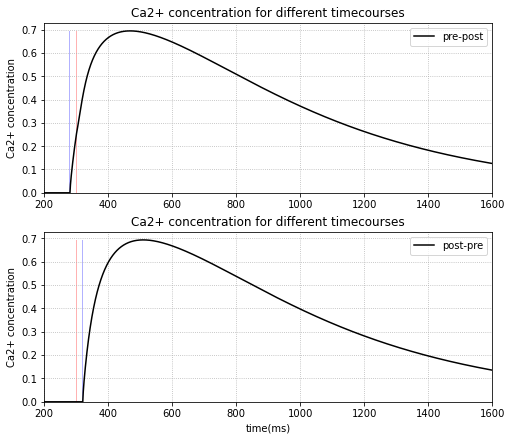

In [13]:
# Fig.3: Ca2+ concentration for different timecourses delta_t = -20/20 ms
alpha_p = 0.9
bar_g_nmda = 0.4 # origin value is 0.01, but it doesn't make sense in the paper
delta_T = [-20, 20]
Legend = ['pre-post', 'post-pre']
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)
for i in range(2):
  # spiking setting
  delta_t = delta_T[i]
  t_duration = 1600
  idx_duration = int(t_duration/dt)
  pre_I = bp.ops.zeros(idx_duration)
  post_I = bp.ops.zeros(idx_duration)
  idx_pre_spike = int((300+delta_t)/dt)
  idx_post_spike = int(300/dt)
  idx_spike_duration = int(1/dt)
  pre_I[idx_pre_spike: idx_pre_spike+idx_spike_duration] = 160
  post_I[idx_post_spike: idx_post_spike+idx_spike_duration] = 157

  # run model
  neu1 = LIF(1, monitors=['V', 'V_lp'])
  neu2 = LIF(1, monitors=['V'])
  syn1 = Synapse(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['c_Ca'])
  net1 = bp.Network(neu1, syn1, neu2)
  net1.run(t_duration, inputs=[(neu1, 'input', pre_I), (neu2, 'input', post_I)])

  # plot
  ax = fig.add_subplot(gs[i, 0])
  plt.title('Ca2+ concentration for different timecourses')
  plt.plot(neu1.mon.ts, syn1.mon.c_Ca, label=Legend[i], color='k')
  plt.legend()
  # add ylabel
  ax.set_ylabel('Ca2+ concentration')
  # set axis lim
  plt.xlim(200, 1600)
  plt.ylim(0, )
  # note the pre/post firing
  plt.fill_between([300-2,300+2],max(syn1.mon.c_Ca[:,0]),facecolor='r',alpha=0.3)
  plt.fill_between([300+delta_t-2,300+delta_t+2],max(syn1.mon.c_Ca[:,0]),facecolor='b',alpha=0.3)
  plt.grid(linestyle='dotted')

plt.xlabel('time(ms)')

# tips：修改参数alpha_p从0.5到0.9， 修改bar_g_nmda从0.01到0.4以满足I_Ca的量纲大小，达到文中效果

## Spike Time Dependence of Postsynaptic Calcium Concentration

- calcium peak amplitude in a spine in good approximation depends exponentially on the temporal difference of the presynaptic and the postsynaptic spiking.
- the calcium influx is largest, if the presynaptic cell fires shortly before the postsynaptic cell. This makes the calcium signal an appropriate
candidate carrier of information on causal correlation

$$
\rho_{glu}, t_{glu}, \tau_{rise,nmda}\\
\Delta t_{syn}=t_{BP} - t_{glu}\\
\Delta t_{syn} = t_{BP} - t_{glu}=t_{post}+d_{BP}-(t_{pre}+d_{glu})=\Delta t + d_{BP}-d_{glu}\\
n(t) = n_0H(t-t_{glu}-\tau_{rise,nmda})e^{-\frac{t-t_{glu}-t_{rise,nmda}}{\tau_{nmda}}},\ 
i_{Ca}=q_0\delta(t-t_{BP})\\
q = \int i_{Ca}(t-t_{BP})n(t) dt = \int q_0\delta(t-t_{BP})n_0H(t-t_{glu}-t_{rise,nmda})e^{-\frac{t-t_{glu}-t_{rise,nmda}}{\tau_{nmda}}} dt\\
= q_0n_0H(\Delta t_{syn}-\tau_{rise,nmda})e^{-\frac{\Delta t_{syn}-t_{rise,nmda}}{\tau_{nmda}}}\\
=q_0n_0H(\Delta t - (\tau_{rise,nmda}+d_{glu}-d_{BP}))e^{-\frac{\Delta t - (\tau_{rise,nmda}+d_{glu}-d_{BP})}{\tau_{nmda}}}\\
=q_0n_0H(\Delta t - \tau_{rise})e^{\frac{\Delta t - \tau_{rise}}{\tau_{nmda}}}\\
q(t_{BP}) = \int_{-\infty}^{\infty} i_{Ca}(t-t_{BP})n(t-t_{glu})dt=\int_0^{\infty} i_{Ca}(t)n(t-t_{glu}+t_{BP})dt\\
=\int i_{Ca}(t)n(t+\Delta t_{syn})dt=\int i_{Ca}(t)e^{-\frac{t}{\tau_{nmda}}} dt e^{-\frac{\Delta t_{syn}-\tau_{rise,nmda}}{\tau_{nmda}}}=q'_0e^{-\frac{\Delta t_{syn}-\tau_{rise,nmda}}{\tau_{nmda}}}(if \Delta t_{syn}\geq \tau_{rise,nmda})
$$

In [9]:
# paraeters setting
rho_glu = 0 # glutamate concentration
t_glu = 0 # time of presynaptic spiking to increase the glutamate concentration
nt = 0 # fraction of the NMDA receptors bind to glutamte
tau_rise_nmda = 5-10 # a rise time n(t) reaches maxium n_0 [ms] 
# we choose this maxium n_0 to be th unit of n, after rho_glu(t) decay back to its resting value, the receptors unbind and n(t) to 0
# we neglect the continuous binding process and instead assume that the number n of glutamate bound NMDA receptors jumps to a positive value after the rise time
n_0 = 1
V_spine = 0 # arriving of a postsynaptic back-propagating action potential(bpAP) depolarizes the spine(V_spine), removes the block and calium ion flow into the spine
t_BP = 5 # arrival time of a postsynaptic bpAP at the spine [ms]
delta_t_syn = t_BP - t_glu # thus receptor mediated conductivity depends on the relative timing delta_t_syn
q = 0 # the total amout of Ca2+ influx, which is proportional to n(t_BP), therefore depends on the relative timing delta_t_syn
t_post = 10 # spiking time of the postsynapse [ms]
t_pre = 0  # spiking time of the presynapse [ms]
delta_t = t_post - t_pre # t_pre spiking time in the presynaptic neuron's soma, t_post spiking time in the postsynaptic neuron
tau_nmda = 32 # time constant of exponential decay [ms]
d_BP = 1 # the delay for bpAP
d_glu =1 # delay between presynaptic spike and glutamte release
q = 0 # total Ca2+ influx
q_0 = 1
tau_rise = 0 # tau_risr_nmda+d_glu-d_BP [ms]


## Ca2+ Transients Caused by Correlated Irregular Spiking

- In this section we investigate how much information about the correlation between presynaptic and postsynaptic events is contained in the Ca2+ signal if the spiking activity is irregular. 
- we simulate the presynaptic and the postsynaptic spiking as Poisson processes with rates $ν_i$ and $ν_o$, respectively. Both processes share a fraction of spikes that appear in the spike trains with a fi xed temporal distance $\Delta t$.
- he information about correlation between the
presynaptic and the postsynaptic events enters the probability
distribution ρ(a) and is therefore exhibited in the amplitude dis-
tribution of Ca2+ transients in the postsynaptic spine

$$
n(t)=n_0\sum e^{-\frac{t-t_{pre}-\tau_{rise}}{\tau_{nmda}}}\\
q_A(t_{post})=\sum e^{-\frac{t_{post}-t_{pre}-\tau_{rise}}{\tau_{nmda}}}\\
\rho_0(q)=Cq^{r-1}(0<q\leq 1), =q^{r-1}(C-r\int_1^{q}\rho_0(x-1)x^{-r}dx)(q>1)\\
r=v_i\tau_{nmda},\ C =\frac{e^{-r\gamma}}{\Gamma(r)},\ \gamma=0.577215665\\
\rho(a)=\varepsilon\rho_{0}(a-\Delta a)+(1-\varepsilon)\rho_{0}(a),\ \Delta a = e^{-(\Delta t-\tau_{rise})/\tau_{nmda}} 
$$

In [10]:
# parameters setting
v_i = 5 # rate of Possion process for presynaptic spiking 
v_o = 5 # rate of Possion process for postsynaptic spiking
epsilon = 0 # correlation coeffient for the strength of the temporal correlation. which is the conditional probability of a pair event
gamma_0 = 0.577215665
N = 80 # average number of CAMKII molecules in a PSD
 

In [ ]:
def probability_distribution(q, v_i):
    '''
    input:
    the Ca influx: q
    Possion efficient of input spike: v_i
    output:
    probability at q: rho_0
    '''
    r = v_i*tau_nmda
    C = np.exp(-r*gamma_0)/gamma(gamma_0)
    if q <= 1:
        rho_0 = C*q**(r-1)
    elif q > 1:
        rho_0 = q**(r-1)*(C-r)
    return rho_0


## A Counter for Correlated Events

- Appendix: Probability Distribution for the Number of Active CaMKII Molecules
- Mean First Passage Time Problem for the Number of CaMKII Molecules
$$
p_{-}=P(\Theta_b\leq a\leq \Theta_l|postsynaptic spike), \Delta t\leq \Delta t_{+}\\
p_{+}=P(a\geq\Theta_h|postsynaptic spike), \Delta t\leq \Delta t_{+}\\
plus-event:\Delta\geq\Theta_h\\
p_{+}(\varepsilon)=\int_{\Theta_h}^{\infty}\rho(a)da=(1-\varepsilon)\int_{\Theta_h}^{\infty}\rho_0(a)da + \varepsilon\int_{\Theta_h}^{\infty}\rho_0(a-\Delta a)da\\
=(1-\varepsilon)(1-\int_0^{\Theta_h}\rho_0(a)da)+\varepsilon=1 + (\varepsilon-1)\frac{C}{r}\Theta_h^{r}\\
minus-event:\Theta_b<\Theta_l<\Theta_h\leq \Delta a\\
p_{-}(\varepsilon)=\int_{\Theta_b}^{\Theta_l}\rho(a)da=(1-\varepsilon)\int_{\Theta_b}^{\Theta_l}\rho_0(a)da + \varepsilon\int_{\Theta_b}^{\Theta_l}\rho_0(a-\Delta a)da\\
=(1-\varepsilon)\frac{C}{r}(\Theta_l^r-\Theta_b^r)
$$

In [11]:
# parameters setting
Delta_t_plus = 20  # the range of teporal distance
Theta_h = np.exp(-Delta_t_plus/tau_nmda) # the highest threshold of calcium influx - plus event
Theta_l = 0.75*Theta_h # the low threshold of calcium influx - no man land
Theta_b = 0.3*Theta_h # the base threshold of calcium influx - minus event
prob_p = 0.01 # the probability of each CaMKII molecule to be activated
prob_q = 0.01 # the probability of each CaMKII molecule to be deactivated
# p.q without experiment reference. The smaller these values, the narrower the distribution of active CAMKII molecules
X_m = N*0.8 # the minimal amount of active CAMKII molecules for synapse maturation by insertion of new AMPA receptors
X_d = N*0.3 # the minimal amount of the synapse pruning, X_d < X_m.


In [ ]:
def CAMKII_transform(x, a, p, N, Theta_h, Theta_b, Theta_l):
    '''
    input:
    x is the number of active CAMKII
    a is the Ca influx
    p is the probability of phosphorylate
    N is the number of all CAMKII
    output: 
    updated x
    '''
    if a > Theta_h:
        x  = x + np.random.binomial(N-x, p)
    elif a > Theta_b and a <= Theta_l:
        x = x - np.random.binomial(x, p)
    return x

def probability_plus_event(epsilon):
    '''
    input:
    correlation efficient: epsilon
    output:
    probability of plus-event: p_p 
    '''
    r = v_i*tau_nmda
    C = np.exp(-r*gamma_0)/gamma(gamma_0)
    p_p = 1 + (epsilon - 1)*C/r*Theta_h**r
    return p_p

def probability_minus_event(epsilon):
    '''
    input:
    correlation efficient: epsilon
    output:
    probability of plus-event: p_p 
    '''
    r = v_i*tau_nmda
    C = np.exp(-r*gamma_0)/gamma(gamma_0)
    p_m = (1 - epsilon)*C/r*(Theta_l**r-Theta_b**r)
    return p_m

def equilibrium_active_molecules(p_p, p_m, prob_p, prob_q, N):
    return N*p_p*prob_p/(p_p*prob_p + p_m*prob_q)

def start_recoding(t_first, t_SP):
    '''
    start at beginning of spike register
    '''
    while t_SP <= t_first:
        '''
        counter_SP = counter_SP +1
        move to next element
        '''
def end_recording(t_last, t_SP):
    '''
    start at beginning of spike register
    '''
    while t_SP <= t_last:
        '''
        counter_SP = counter_SP - 1
        move to next element
        '''


## Rate Homeostasis by Synaptic Pruning

- If new synapses are created with a constant rate the input connectivity to the neuron has a stable fi xed point at k* where synaptic death is just compensated by synapse creation. The firing rate of the neuron assumes a corresponding fi xed fi ring rate ν*o. 
$$
C_{io}(\tau)=v_iv_o+c_{io}(\tau)\\
Pr(t_{pre}\in[t-\tau, t-\tau+d\tau]|post\quad spike\quad at\quad t)=v_id\tau+\frac{1}{v_o}c_{io}(\tau)d\tau\\
\frac{dk}{dt}=-k\eta_1(v_o(k),k)\\
k(0)=k_0
$$

## Cooperation and Competition by Spatial Input Correlation

- the calcium based correlation detection mechanism naturally leads to cooperation between synapses, which stabilizes coactive inputs.

$$
\frac{dn_p}{dt}=-n_p\eta_{1,possion}(v_o(n_p,n_c),n_p,n_c)\\
\frac{dn_c}{dt}=-n_c\eta_{1,mip}(v_o(n_p,n_c),n_p,n_c)\\
n_p(0)=n_{p,0},\quad n_c(0)=n_{c,0}
$$

# Appendix

## Probability distribution for the number of active CaMKII molecules
- Markov process
$$
P(x,y) = H(y-x)\sim{p}_{+}B(y-x|p,N-x)+H(x-y)\sim{p}_{-}B(x-y|q,x)\\
\rho(y) = \sum_{x=0}^{N}\rho(x)P(x,y),\quad 0 = \sum_{x=0}^{N}\rho(x)(P(x,t)-\delta(x,y))\\
\delta_{y,0}= \sum_{x=0}^{N}\rho(x)(P(x,t)-\delta(x,y)+\delta_{y,0})\\
\mu(t+\Delta t)=\langle x(t+\Delta t )\rangle\\
\frac{d\mu(t)}{dt}=\lim_{\Delta t\to 0}\frac{\langle x(t+\Delta t)\rangle-\langle x(t)\rangle}{\Delta t}=\lambda\tilde{p}_{+}Np-\mu(t)\lambda(\tilde{p}_{+}p+\tilde{p}_{-}q)\\
\mu_{eq}=\langle x\rangle_{eq}=N\frac{\tilde{p}_{+}p}{\tilde{p}_{+}p+\tilde{p}_{-}q}\\
\mu(t)=\mu(0)e^{-t\lambda(\tilde{p}_{+}p+\tilde{p}_{-}q)}+\mu_{eq}(1-e^{-t\lambda(\tilde{p}_{+}p+\tilde{p}_{-}q)})\\
\tau_{relax}=\frac{1}{\lambda(\tilde{p}_{+}p+\tilde{p}_{-}q)}
$$
$\sigma_{eq}$ can be determined Analogously, thus approximating as a Gaussian

## Mean first passage time problem for the number of CaMKII molecules
$$
\frac{\partial \rho}{\partial t}=-\frac{\partial}{\partial x}S(x)\rho
$$
$S(x)$ denotes the probability flux operator. The process can be desribed as a diffusion and the equilibrium distribution is given by a Gaussian $\rho_0(x)=N(\mu_{eq},\sigma_{eq}^2)$
$$
0 = S(x)\rho_0(x)\to S(x)=D(-(x-\mu_{eq})-\sigma^2_{eq}\frac{\partial}{\partial x})
$$
$D$ control the time scale
$$
A_1(x)=-D(x-\mu_{eq}),\quad D = \lambda(\tilde{p}_{+}p+\tilde{p}_{-}q)
$$
To simplify, rescale the variable $y=\frac{x-\mu_{eq}}{\sigma_{eq}}$. Then end with confluent hypergeometric functions in Quantum mechanics.

## Algorithmic implementation of synapse maturation and synapse death